In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import sys
sys.path.append('../series_alignment')
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import MinMaxScaler
import DLS
import series_alignment 


## Load Experimental Data

In [3]:
#Load data for bilayer 
#path = '../Data/SAXS/Kinetics/ESAXS_Sub/'
path = '../Data/DLS/Kinetics_data/'
filenames = sorted(os.listdir(path))

In [4]:
df = pd.read_excel('../Data/DLS/Assembly_kinetics_data.xlsx').values[:,5:].T
data = df.astype('float')
#df = np.flip(df)
sizes = data[1:71,0].reshape(-1,1)
intensity = data[71:,:]
n_samples = 19
exp_DLS_data = []
for i in range(0,n_samples):
    sample_int = intensity[:,i*3:i*3 + 3]
    avg = np.mean(sample_int, axis=1).reshape(-1,1)
    scaler = MinMaxScaler()
    avg = scaler.fit(avg).transform(avg)
    exp_DLS_data.append(np.hstack((sizes, avg)))
    if i == 0:
        avg_data_silica = avg.reshape(-1,1)
    else:
        avg_data_silica = np.hstack((avg_data_silica, avg.reshape(-1,1)))

In [5]:
len(exp_DLS_data)

19

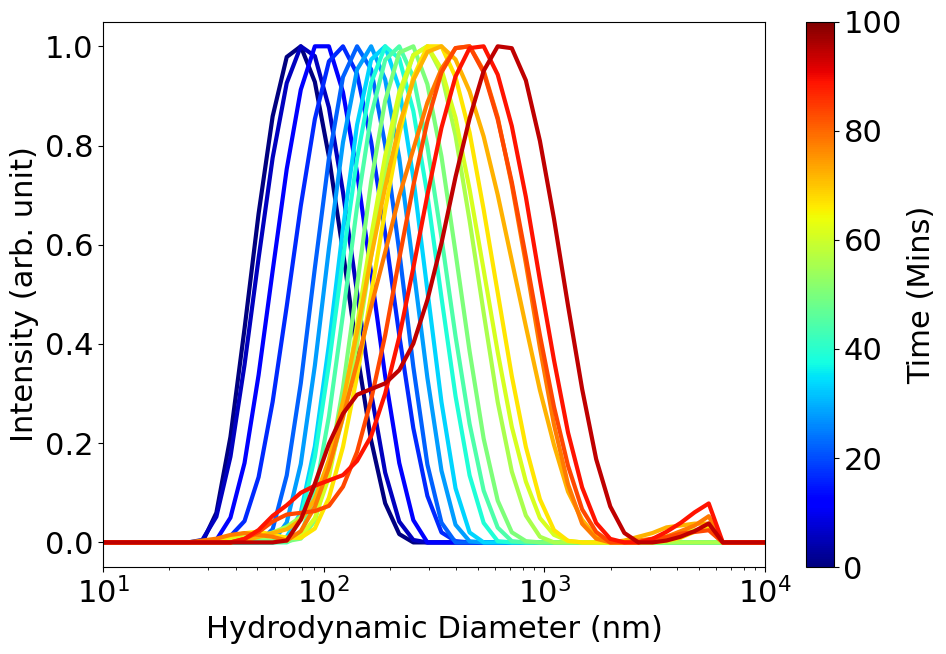

In [6]:
norm = colors.Normalize(vmin=0, vmax=100)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
times = np.linspace(0,100, len(exp_DLS_data))
plt.rcParams.update({'font.size': 22})
sim_saxs_data = []
fig, ax = plt.subplots(figsize=(10,7))
for i in range(len(exp_DLS_data)-1):
    ax.plot(sizes, exp_DLS_data[i][:,1], linewidth = 3, color=sm.to_rgba(times[i]))
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Intensity (arb. unit)')
    ax.set_xlabel('Hydrodynamic Diameter (nm)')
    ax.set_xlim([1e1, 1e4])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time (Mins)')
plt.tight_layout()
#plt.savefig('../Figures/Exp_DLS.png', dpi=600, bbox_inches="tight")



## Load Simulated Data

In [7]:
file_path = '../Data/DLS/Simulated_DLS_10/'
filenames = sorted(os.listdir(file_path))
for i in range(len(filenames)):
    if len(filenames[i]) == 6:
        new_name = filenames[i][0:5] + '0' + filenames[i][-1]
        os.rename(file_path + filenames[i], file_path + '/' + new_name)

In [8]:
file_path = '../Data/DLS/Simulated_DLS_10/'
filenames = sorted(os.listdir(file_path))
sim_DLS_data = []
for i in range(0, len(filenames)):
    DLS_data = pd.read_csv(file_path + filenames[i], skiprows=1, delimiter= ' ') #this code loads the data incorrectly so modify the correct column titles
    radius_of_gyration = DLS_data['Cluster Size'].values*2.0*25*2*1e-9 #meters 
    radius_of_gyration = radius_of_gyration[radius_of_gyration != 0]
    cluster_size = np.round(DLS_data['Cluster Identifier'].values)
    cluster_size = cluster_size[cluster_size != 0]
    hydrodynamic_radius = radius_of_gyration/0.77 #assuming spherical clusters 

    clusters = [
        {"N": int(N), "Rg": float(Rg), "Rh": float(Rh)}
        for N, Rg, Rh in zip(cluster_size, radius_of_gyration, hydrodynamic_radius)
    ]
    # ---- example usage ----
    # Instrument settings
    lam = 632.8e-9        # HeNe laser (m)
    n_medium = 1.333      # water
    theta = np.deg2rad(173)  # backscatter example
    q = (4*np.pi*n_medium/lam) * np.sin(theta/2)
    kB = 1.380649e-23  # J/K
    T = 298.15            # K
    eta = 0.00089         # Pa*s

    tau = np.logspace(-6, 0, 100)  # correlation times (s) matching your experiment
    g2_sim, g1_sim, Ds, wts = DLS.build_g2(clusters, tau, q, T, eta, beta=0.85)

    # Now invert like the instrument would
    #Dgrid, Rh_grid, w_intensity = invert_g2_to_distribution(g2_sim, tau, q, T, eta, beta=0.85)
    Dgrid, wD, info = DLS.contin_like_invert(g2_sim, tau, q, T=T, eta=eta)
    Rh_grid = info["Rh_grid"]*1e9 
    Rh_grid = np.flip(Rh_grid)
    scaler = MinMaxScaler()
    wD = scaler.fit(wD.reshape(-1,1)).transform(wD.reshape(-1,1))
    wD = np.flip(wD)
    dls_data = np.hstack((Rh_grid.reshape(-1,1), wD.reshape(-1,1)))
    sim_DLS_data.append(dls_data)
    # Dgrid/Rh_grid with weights w_intensity is your synthetic DLS "size distribution"
    # Plot Rh_grid vs w_intensity and compare peak/width to experimental inversion.

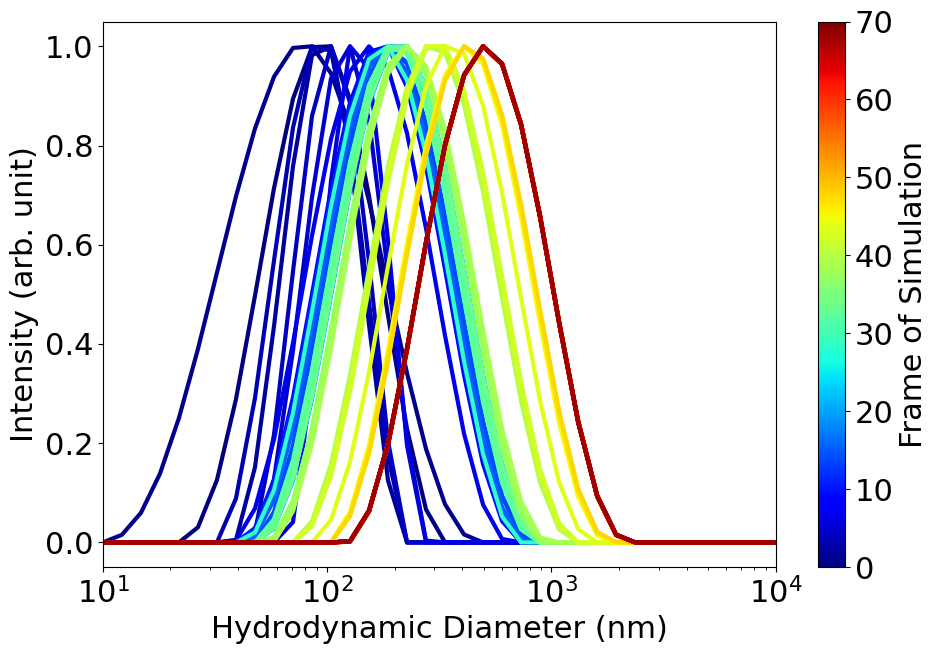

In [9]:
norm = colors.Normalize(vmin=0, vmax=70)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
times = np.linspace(0,68, len(sim_DLS_data))

sim_saxs_data = []
fig, ax = plt.subplots(figsize=(10,7))
for i in range(len(sim_DLS_data)):
    #fig, ax = plt.subplots()    
    ax.plot(sim_DLS_data[i][:,0], sim_DLS_data[i][:,1], linewidth = 3, color=sm.to_rgba(times[i]))
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Intensity (arb. unit)')
    ax.set_xlabel('Hydrodynamic Diameter (nm)')
    #ax.set_xlim([0.002, 0.05])
    #ax.set_ylim([0, 0.025])
    ax.set_xlim([1e1, 1e4])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Frame of Simulation')
plt.tight_layout()
#plt.savefig('../Figures/Simulated_DLS.png', dpi=600, bbox_inches="tight")


## Prepare Data

In [11]:
score_matrix = series_alignment.create_distance_matrix(exp_DLS_data, sim_DLS_data,'peak_position')

## Align the Curves Based on Distance

In [12]:
idx_cols, total_dist = series_alignment.align_monotone_min(score_matrix)
print(total_dist)

1159.3739130434778


## Compare Curves by Plotting

In [15]:
def plot_compared_curves(exp_data, sim_data, idx_sim, q_range=None):
    norm = colors.Normalize(vmin=0, vmax=100)
    cmap = cm.jet
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    times = np.linspace(0,100,len(exp_data))
    for i in range(len(idx_sim)):
        fig, ax = plt.subplots(figsize=(10,7))
        d_ap, q_ref, I_exp, I_sim = compare_curves(exp_data[i], sim_data[idx_sim[i]], q_range=q_range)
        ax.plot(q_ref, I_exp, linewidth = 3, color=sm.to_rgba(times[i]))
        ax.plot(q_ref, I_sim, linewidth = 3, color='k', label = 'Simulated Index: ' + str(idx_sim[i]))
        #ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('Intensity (arb. unit)')
        ax.set_xlabel('q ($\\AA^{-1}$)')
        ax.set_xlim([10, 1000])
        #plt.legend()
        #cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
        #cbar.set_label('Frame of Simulation (normalized)')
        plt.tight_layout()

def plot_compared_curves_single(exp_data, sim_data, idx_sim, q_range=None):
    norm = colors.Normalize(vmin=0, vmax=100)
    cmap = cm.jet
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    times = np.linspace(0,100,len(exp_data))
    fig, ax = plt.subplots(figsize=(10,7))
    for i in range(len(idx_sim)):
        d_ap, q_ref, I_exp, I_sim = compare_curves(exp_data[i], sim_data[idx_sim[i]], q_range=q_range)
        ax.plot(q_ref, I_exp, linewidth = 3, color=sm.to_rgba(times[i]))
        ax.plot(q_ref, I_sim, linewidth = 5, color='k', label = 'Simulated Index: ' + str(idx_sim[i]))
        #ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('Intensity (arb. unit)')
        ax.set_xlabel('q ($\\AA^{-1}$)')
        ax.set_xlim([10, 1000])
        #plt.legend()
        #cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
        #cbar.set_label('Frame of Simulation (normalized)')
        plt.tight_layout()

def plot_compared_curves_grid(exp_data, sim_data, idx_sim, q_range=None):
    norm = colors.Normalize(vmin=0, vmax=100)
    cmap = cm.jet
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    times = np.linspace(0,100,len(exp_data))
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('Intensity (arb. unit)', labelpad = 0)
    plt.xlabel('Hydrodynamic Diameter (nm)', labelpad=0)
    gs = fig.add_gridspec(4, 4, hspace=0, wspace=0)
    ax = gs.subplots(sharex='col', sharey='row')
    plt.plot(0,0,linewidth = 3, color='k', label='Simulated Data')
    plt.legend(loc='lower right', bbox_to_anchor=(1, 4.02), ncol=3, fontsize=14)
    #for i in range(len(idx_sim)):
    i = 0 
    for row in range(0, 4):
        for col in range(0, 4):
            axs = ax[row, col]
            axs.tick_params(
            axis="x",
            which="both",
            labelbottom=False)  # hides the numbers)
            i = i + 1
            d_ap, q_ref, I_exp, I_sim = series_alignment.compare_curves(exp_data[i], sim_data[idx_sim[i]], 'peak_position', q_range=q_range)
            axs.scatter(q_ref, I_exp, linewidth = 0.5, color=sm.to_rgba(times[i]))
            axs.plot(q_ref, I_sim, linewidth = 3, color='k', label = 'Simulated Index: ' + str(idx_sim[i]))

            #axs.set_yscale('log')
            axs.set_xscale('log')
            axs.set_xlim([10, 2000])
            #axs.set_ylim([0.1, 10])

            axs.set_yticks([])
            axs.set_xticks([])
            axs.set_xticklabels([])
            # ax.set_ylabel('Intensity (arb. unit)')
            #axs.set_xlabel('q ($\\AA^{-1}$)')

            #plt.legend()
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Experimental Data Time (Mins)')
    #plt.savefig('../Figures/DLS_data_match.png', dpi=600, bbox_inches="tight")



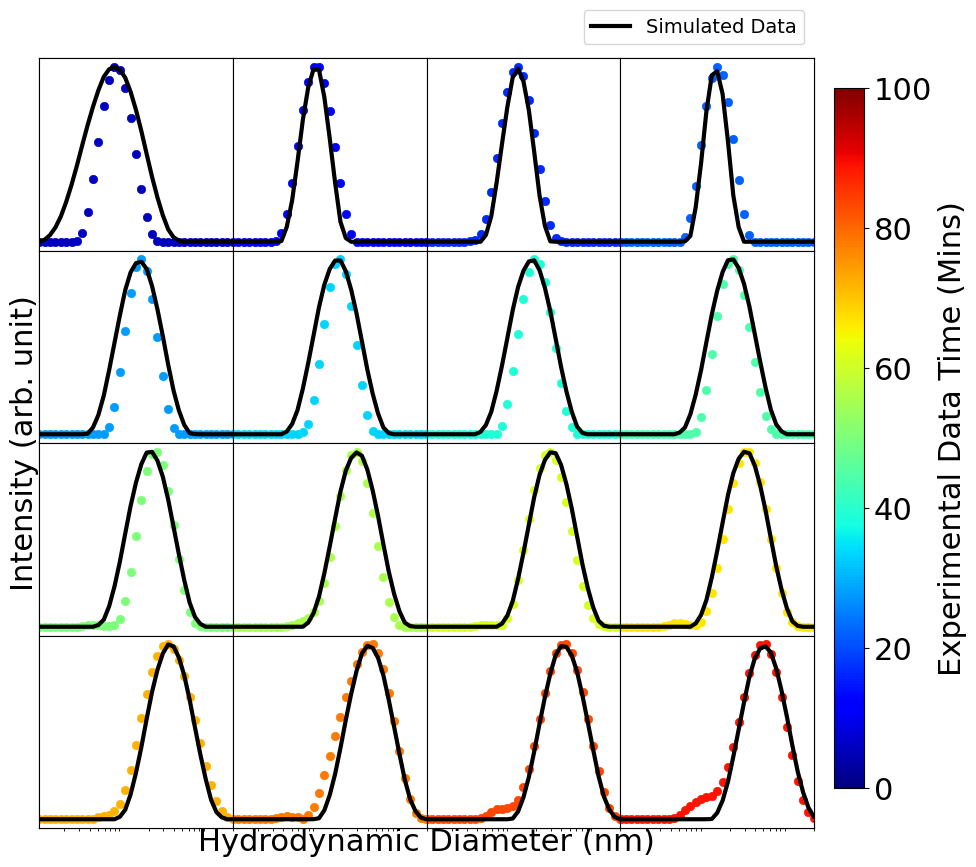

In [16]:
plot_compared_curves_grid(exp_DLS_data, sim_DLS_data, idx_cols)

In [17]:
idx_cols

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(16),
 np.int64(18),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(43),
 np.int64(44),
 np.int64(45),
 np.int64(48),
 np.int64(49),
 50]